In [1]:
pip install deap

     |████████████████████████████████| 163kB 14.7MB/s 


In [2]:
import operator
import random
import numpy as np
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Definición de los datos de entrenamiento
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


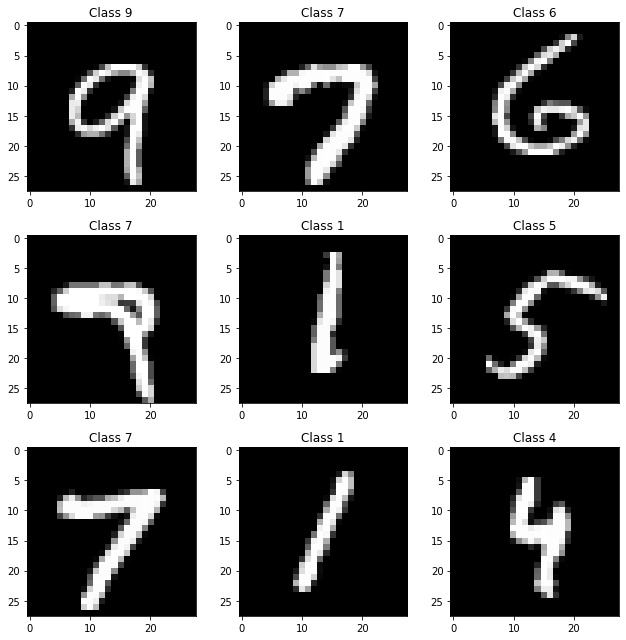

In [5]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

In [6]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.
X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')
X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [7]:
nb_classes = 10 # number of unique digits
Y_train = keras.utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.to_categorical(y_test, nb_classes)

In [8]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    smin=None, smax=None, best=None)

In [17]:
#Se define la función objetivo, x tiene 3 posiciones
def funcion_objetivo(x):
  
    for i in range(len(x)):
        if x[i] > 100 or x[i] < 10:
            return 1,
    NC1= round(x[0])
    NC2= round(x[1])    
    NC3= round(x[2])
    modelo=keras.models.Sequential()
    modelo.add(keras.layers.Dense(NC1,input_dim=784,activation='relu'))
    modelo.add(keras.layers.Dense(NC2,activation='relu'))
    modelo.add(keras.layers.Dense(NC3,activation='relu'))    
    modelo.add(keras.layers.Dense(10,activation='softmax')) 
    modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    modelo.fit(X_train, Y_train,
          batch_size=128, epochs=5,
          verbose=0)
    
    score = modelo.evaluate(X_test, Y_test, verbose=0)
    return - score[0],

In [18]:
def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size)) 
    part.speed = [random.uniform(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

In [19]:
def updateParticle(part, best, phi1, phi2):
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
    part[:] = list(map(operator.add, part, part.speed))

In [26]:
toolbox = base.Toolbox()
#size psition number
toolbox.register("particle", generate, size=3, pmin=10, pmax=100, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=2.0, phi2=2.0)
#toolbox.register("evaluate", benchmarks.h1)
toolbox.register("evaluate", funcion_objetivo)

In [27]:
#Función para graficar el proceso de la evolución
def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")
    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    ax1.fill_between(gen, fit_mins, fit_maxs, 
                     where=fit_maxs >= fit_mins, facecolor='g', alpha = 0.2)
    ax1.set_xlabel("Generacion")
    ax1.set_ylabel("Fitness")
    ax1.set_ylim([-100, 10])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.savefig("Convergencia.eps", dpi = 300)

In [29]:
#def main():
pop = toolbox.population(n=5)
hof = tools.HallOfFame(1) 
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields
GEN = 10
best = None
for g in range(GEN):
    for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
    for part in pop:
            toolbox.update(part, best)
    # Gather all the fitnesses in one list and print the stats
    logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
    print(logbook.stream)

gen	evals	avg      	std      	min      	max       
0  	5    	-0.111213	0.0175364	-0.136637	-0.0929438
1  	5    	-0.100358	0.0134743	-0.120685	-0.0821553
2  	5    	-0.1003  	0.00901005	-0.112879	-0.0889987
3  	5    	-0.103472	0.0153961 	-0.120065	-0.0797756
4  	5    	-0.099489	0.0095712 	-0.115409	-0.089657 
5  	5    	-0.0947266	0.0122713 	-0.113217	-0.079764 
6  	5    	-0.0943678	0.00964064	-0.111397	-0.0849948
7  	5    	-0.0946301	0.00978154	-0.113441	-0.0856359
8  	5    	-0.0918937	0.00714501	-0.103075	-0.0839075
9  	5    	-0.0977574	0.00756213	-0.111811	-0.0899184


In [30]:
print(best)
print(best.fitness)

[81.89114916433991, 83.0587644723786, 54.19143521677435]
(-0.0797639712691307,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  from ipykernel import kernelapp as app
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


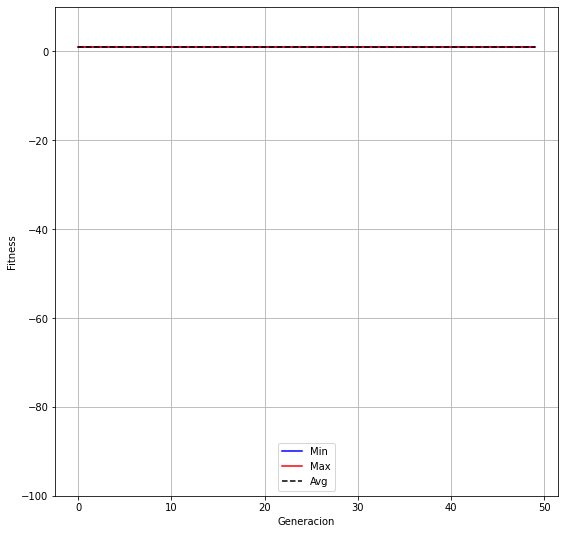

In [24]:
plot_evolucion(logbook)

In [31]:
x=best

print(x)   
NC1= round(x[0])
NC2= round(x[1])    
NC3= round(x[2])
modelo=keras.models.Sequential()
modelo.add(keras.layers.Dense(NC1,input_dim=784,activation='relu'))
modelo.add(keras.layers.Dense(NC2,activation='relu'))
modelo.add(keras.layers.Dense(NC3,activation='relu'))    
modelo.add(keras.layers.Dense(10,activation='softmax')) 
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelo.fit(X_train, Y_train,
       batch_size=128, epochs=10,
       verbose=0)
    
score = modelo.evaluate(X_test, Y_test, verbose=0)
print(score)

[81.89114916433991, 83.0587644723786, 54.19143521677435]
[0.08045248687267303, 0.9789000153541565]
